# Plan-and-Execute


![](./assets/langgraph-plan-and-execute.png)

---

## Plan-and-Execute?



- **장기 계획 수립**:
복잡한 작업을 수행하기 전에 큰 그림을 그리는 장기 계획을 수립
- **단계별 실행 및 재계획**:
세운 계획을 단계별로 실행하고, 각 단계가 완료될 때마다 계획이 여전히 유효한지 검토한 뒤 수정할 수 있음
  

---

**주요 내용**

- **도구 정의**: 사용할 도구 정의
- **실행 에이전트 정의**: 실제 작업을 실행하는 에이전트 생성
- **상태 정의**: 에이전트의 상태 정의
- **계획 단계**: 장기 계획을 세우는 단계 생성
- **재계획 단계**: 작업 진행 상황에 따라 계획을 재수정하는 단계 생성
- **그래프 생성 및 실행**: 이러한 단계들을 연결하는 그래프 생성 및 실행

---


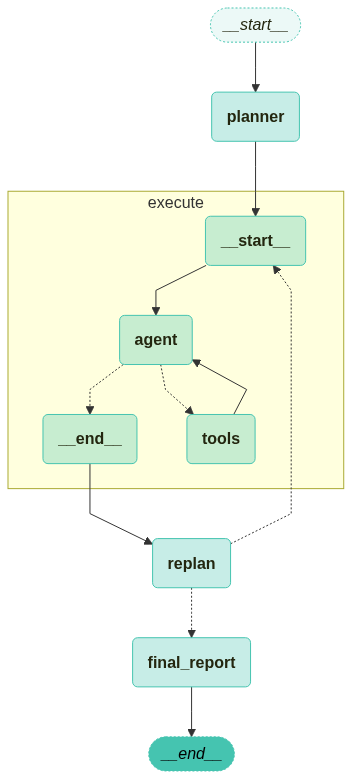

## 환경 설정

In [ ]:
!pip -q install langchain langchain-openai langchain-community duckduckgo-search gradio langgraph langchain-teddynote

In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

import os

In [ ]:
# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata

# api_key=userdata.get('api_key')
# api_key2=userdata.get('api_key2')
# api_key3=userdata.get('api_key3')
# os.environ["OPENAI_API_KEY"] = api_key
# os.environ["LANGCHAIN_API_KEY"] = api_key2
# os.environ["TAVILY_API_KEY"] = api_key3

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "LangGraph_plan_ex"


from langchain_teddynote.tools.tavily import TavilySearch
import os

실습에 활용할 모델명 정의

In [4]:
from langchain_teddynote.models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


## 도구 정의



In [5]:
from langchain_teddynote.tools import TavilySearch

# Tavily 검색 도구 초기화
tools = [TavilySearch(max_results=3)]

## 작업 실행 에이전트 정의



In [7]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)


# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [8]:
# 에이전트 실행
agent_executor.invoke(
    {"messages": [("user", "랭체인 한국어 튜토리얼에 대해서 설명해줘")]}
)

{'messages': [HumanMessage(content='랭체인 한국어 튜토리얼에 대해서 설명해줘', additional_kwargs={}, response_metadata={}, id='d8b59e43-f7a3-4c2f-82e9-51efe4e11b72'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BQiNIHqQi6t6QdBH3e07qFfE', 'function': {'arguments': '{"query":"랭체인 한국어 튜토리얼"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 159, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CC6yEkivIzVaZ3YJEDhgd0IDfn3mI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--65e9d693-a1c3-4f59-ae77-17c14506e4c2-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭체인 한국어 튜토

## 상태 정의

- `input`: 사용자의 입력
- `plan`: 현재 계획
- `past_steps`: 이전에 실행한 계획과 실행 결과
- `response`: 최종 응답

In [9]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# 상태 정의
class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]

## 계획(Plan) 단계


In [10]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Plan)

In [12]:
# Planner 실행
planner.invoke(
    {
        "messages": [
            (
                "user",
                "LangGraph 의 핵심 장단점과 LangGraph 를 사용하는 이유는 무엇인가?",
            )
        ]
    }
)

Plan(steps=['LangGraph의 정의와 목적을 이해한다.', 'LangGraph의 주요 기능과 특징을 조사한다.', 'LangGraph의 장점을 나열한다.', 'LangGraph의 단점을 나열한다.', 'LangGraph를 사용하는 이유를 정리한다.'])

## 재계획(Re-Plan) 단계


In [13]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str


class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


# Replanner 생성
replanner = replanner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Act)

## 그래프 생성



In [14]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    # 응답이 사용자에게 반환될 경우
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 추가 단계가 필요할 경우 계획의 단계 리스트 반환
    else:
        next_plan = output.action.steps
        if len(next_plan) == 0:
            return {"response": "No more steps needed."}
        else:
            return {"plan": next_plan}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)

final_report = (
    final_report_prompt
    | ChatOpenAI(model=MODEL_NAME, temperature=0)
    | StrOutputParser()
)


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}

## 그래프 생성



In [15]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

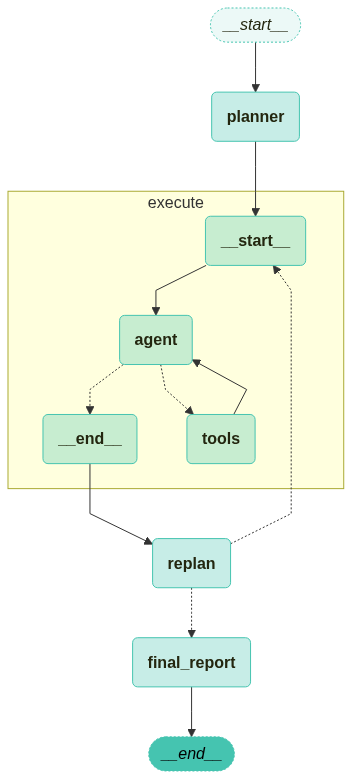

In [16]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

## 그래프 실행

In [17]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점을 설명해줘"
}

invoke_graph(app, inputs, config)


🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Naive RAG와 Modular RAG의 기본 개념을 이해한다.
Naive RAG의 구조와 작동 방식을 조사한다.
Modular RAG의 구조와 작동 방식을 조사한다.
Naive RAG와 Modular RAG의 구조적 차이점을 비교한다.
Naive RAG와 Modular RAG의 작동 방식 차이점을 비교한다.
Modular RAG가 production level에서 가지는 이점을 조사한다.
Naive RAG와 비교하여 Modular RAG의 이점을 정리한다.
Modular RAG의 이점을 production level에서의 사용 사례와 연결하여 설명한다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Naive RAG와 Modular RAG의 기본 개념을 이해하기 위해 각각의 정의와 특징을 살펴보겠습니다.

1. **Naive RAG (Retrieval-Augmented Generation)**:
   - Naive RAG는 정보 검색과 생성 모델을 결합한 접근 방식입니다.
   - 주로 대량의 비구조화된 데이터에서 정보를 검색하고, 이를 기반으로 자연어 생성 모델이 응답을 생성하는 방식입니다.
   - Naive RAG는 검색 단계와 생성 단계를 단순히 결합한 형태로, 구조가 비교적 단순합니다.

2. **Modular RAG**:
   - Modular RAG는 Naive RAG의 구조를 개선하여 모듈화된 형태로 발전시킨 모델입니다.
   - 각 모듈이 독립적으로 최적화될 수 있도록 설계되어 있으며, 검색 모듈과 생성 모듈이 명확히 분리되어 있습니다.
   - 이러한 모듈화는 시스템의 유연성

In [18]:
snapshot = app.get_state(config).values
print(snapshot["response"])

# 최종 보고서: Naive RAG와 Modular RAG의 비교 및 생산 환경에서의 이점

## 개요

본 보고서는 Naive RAG와 Modular RAG의 구조적 차이점과 각각의 이점을 분석하고, 특히 Modular RAG가 생산 환경에서 가지는 이점을 중점적으로 설명합니다. 이를 통해 두 접근 방식의 장단점을 이해하고, 실제 응용에서의 활용 가능성을 평가합니다.

## Naive RAG와 Modular RAG의 기본 개념

### Naive RAG

Naive RAG는 정보 검색과 자연어 생성 모델을 결합한 단순한 구조의 시스템입니다. 주로 대량의 비구조화된 데이터에서 정보를 검색하고, 이를 기반으로 자연어 생성 모델이 응답을 생성하는 방식으로 작동합니다. Naive RAG는 검색 단계와 생성 단계를 단순히 결합한 형태로, 구조가 비교적 단순합니다.

### Modular RAG

Modular RAG는 Naive RAG의 구조를 개선하여 모듈화된 형태로 발전시킨 모델입니다. 각 모듈이 독립적으로 최적화될 수 있도록 설계되어 있으며, 검색 모듈과 생성 모듈이 명확히 분리되어 있습니다. 이러한 모듈화는 시스템의 유연성을 높이고, 특정 모듈을 교체하거나 업그레이드하기 쉽게 만듭니다.

## Naive RAG와 Modular RAG의 구조적 차이점

- **Naive RAG**는 단순한 검색 및 생성 구조로 이루어져 있으며, 검색기와 생성기로 구성됩니다. 이는 구현이 간단하고 직관적이지만, 복잡한 문제 해결에는 한계가 있을 수 있습니다.
- **Modular RAG**는 다양한 기능을 수행하는 여러 모듈로 구성되어 있어 더 복잡하고 유연한 구조를 가지고 있습니다. 모듈화된 설계를 통해 시스템의 확장성과 유지보수성을 높이며, 각 모듈이 독립적으로 작동할 수 있도록 설계되어 있습니다.

## Naive RAG와 Modular RAG의 이점 비교

### Naive RAG의 이점

1. **단순성**: 구조가 단순하여 구현이 비교적 쉽습니다.
2. **빠른 개발*

In [19]:
from IPython.display import Markdown

Markdown(snapshot["response"])

# 최종 보고서: Naive RAG와 Modular RAG의 비교 및 생산 환경에서의 이점

## 개요

본 보고서는 Naive RAG와 Modular RAG의 구조적 차이점과 각각의 이점을 분석하고, 특히 Modular RAG가 생산 환경에서 가지는 이점을 중점적으로 설명합니다. 이를 통해 두 접근 방식의 장단점을 이해하고, 실제 응용에서의 활용 가능성을 평가합니다.

## Naive RAG와 Modular RAG의 기본 개념

### Naive RAG

Naive RAG는 정보 검색과 자연어 생성 모델을 결합한 단순한 구조의 시스템입니다. 주로 대량의 비구조화된 데이터에서 정보를 검색하고, 이를 기반으로 자연어 생성 모델이 응답을 생성하는 방식으로 작동합니다. Naive RAG는 검색 단계와 생성 단계를 단순히 결합한 형태로, 구조가 비교적 단순합니다.

### Modular RAG

Modular RAG는 Naive RAG의 구조를 개선하여 모듈화된 형태로 발전시킨 모델입니다. 각 모듈이 독립적으로 최적화될 수 있도록 설계되어 있으며, 검색 모듈과 생성 모듈이 명확히 분리되어 있습니다. 이러한 모듈화는 시스템의 유연성을 높이고, 특정 모듈을 교체하거나 업그레이드하기 쉽게 만듭니다.

## Naive RAG와 Modular RAG의 구조적 차이점

- **Naive RAG**는 단순한 검색 및 생성 구조로 이루어져 있으며, 검색기와 생성기로 구성됩니다. 이는 구현이 간단하고 직관적이지만, 복잡한 문제 해결에는 한계가 있을 수 있습니다.
- **Modular RAG**는 다양한 기능을 수행하는 여러 모듈로 구성되어 있어 더 복잡하고 유연한 구조를 가지고 있습니다. 모듈화된 설계를 통해 시스템의 확장성과 유지보수성을 높이며, 각 모듈이 독립적으로 작동할 수 있도록 설계되어 있습니다.

## Naive RAG와 Modular RAG의 이점 비교

### Naive RAG의 이점

1. **단순성**: 구조가 단순하여 구현이 비교적 쉽습니다.
2. **빠른 개발**: 복잡한 모듈화 없이 기본적인 기능을 빠르게 통합할 수 있습니다.
3. **적은 초기 비용**: 초기 단계에서 복잡한 시스템을 구축할 필요가 없으므로 비용이 적게 듭니다.

### Modular RAG의 이점

1. **유연성**: 다양한 모듈을 조합하여 시스템을 구성할 수 있어 유연성이 높습니다.
2. **확장성**: 시스템이 커지거나 복잡해질 때, 모듈 단위로 확장할 수 있습니다.
3. **유지보수 용이성**: 모듈화된 구조 덕분에 특정 기능이나 모듈에 문제가 발생했을 때, 해당 부분만 수정하면 됩니다.
4. **재사용성**: 모듈화된 구성 요소는 다른 프로젝트나 시스템에서 재사용할 수 있습니다.
5. **성능 최적화**: 각 모듈을 독립적으로 최적화할 수 있어 전체 시스템의 성능을 향상시킬 수 있습니다.

## Modular RAG의 생산 환경에서의 이점

Modular RAG는 특히 대규모 데이터 처리와 실시간 응답이 중요한 생산 환경에서 다음과 같은 이점을 제공합니다:

- **실시간 데이터 처리**: 최신 정보를 기반으로 한 정확한 응답을 제공합니다.
- **낮은 지연 시간**: 효율적인 검색 알고리즘과 캐싱 전략을 통해 낮은 지연 시간을 유지할 수 있습니다.
- **고급 쿼리 처리**: 복잡한 쿼리나 다양한 데이터 소스를 요구하는 작업에 대해 더 나은 성능을 발휘합니다.

## 결론

Naive RAG는 초기 개발 단계에서의 단순성과 빠른 구현이 장점인 반면, Modular RAG는 유연성과 확장성, 유지보수의 용이성 등 장기적인 관점에서의 이점이 큽니다. 특히, Modular RAG는 생산 환경에서의 실시간 데이터 처리와 고급 쿼리 처리에 유리하여, 대규모 데이터 처리 시스템에서의 활용 가능성이 높습니다.

In [20]:
print(snapshot["response"])

# 최종 보고서: Naive RAG와 Modular RAG의 비교 및 생산 환경에서의 이점

## 개요

본 보고서는 Naive RAG와 Modular RAG의 구조적 차이점과 각각의 이점을 분석하고, 특히 Modular RAG가 생산 환경에서 가지는 이점을 중점적으로 설명합니다. 이를 통해 두 접근 방식의 장단점을 이해하고, 실제 응용에서의 활용 가능성을 평가합니다.

## Naive RAG와 Modular RAG의 기본 개념

### Naive RAG

Naive RAG는 정보 검색과 자연어 생성 모델을 결합한 단순한 구조의 시스템입니다. 주로 대량의 비구조화된 데이터에서 정보를 검색하고, 이를 기반으로 자연어 생성 모델이 응답을 생성하는 방식으로 작동합니다. Naive RAG는 검색 단계와 생성 단계를 단순히 결합한 형태로, 구조가 비교적 단순합니다.

### Modular RAG

Modular RAG는 Naive RAG의 구조를 개선하여 모듈화된 형태로 발전시킨 모델입니다. 각 모듈이 독립적으로 최적화될 수 있도록 설계되어 있으며, 검색 모듈과 생성 모듈이 명확히 분리되어 있습니다. 이러한 모듈화는 시스템의 유연성을 높이고, 특정 모듈을 교체하거나 업그레이드하기 쉽게 만듭니다.

## Naive RAG와 Modular RAG의 구조적 차이점

- **Naive RAG**는 단순한 검색 및 생성 구조로 이루어져 있으며, 검색기와 생성기로 구성됩니다. 이는 구현이 간단하고 직관적이지만, 복잡한 문제 해결에는 한계가 있을 수 있습니다.
- **Modular RAG**는 다양한 기능을 수행하는 여러 모듈로 구성되어 있어 더 복잡하고 유연한 구조를 가지고 있습니다. 모듈화된 설계를 통해 시스템의 확장성과 유지보수성을 높이며, 각 모듈이 독립적으로 작동할 수 있도록 설계되어 있습니다.

## Naive RAG와 Modular RAG의 이점 비교

### Naive RAG의 이점

1. **단순성**: 구조가 단순하여 구현이 비교적 쉽습니다.
2. **빠른 개발*